In [1]:
import pandas as pd

df = pd.read_csv("data/PRESCRIPTION.csv")

In [2]:
import pandas as pd
import re
from difflib import get_close_matches

print("="*60)
print("NORMALISATION DES MÉDICAMENTS VIH - VERSION OPTIMISÉE")
print("="*60)

# ------------------------------------------------------------------
# 1. Charger le dictionnaire VIH
# ------------------------------------------------------------------
df_ref = pd.read_excel("data/bdd.xlsx")

print(f"→ {len(df_ref)} médicaments dans le dictionnaire VIH")
print(f"→ {len(df)} lignes à traiter dans df")

# ------------------------------------------------------------------
# 2. Préparation du dictionnaire VIH (SEULEMENT LES VALEURS UNIQUES)
# ------------------------------------------------------------------
df_ref["nom_commercial"] = df_ref["nom_commercial"].fillna("").astype(str)
df_ref["dci"] = df_ref["dci"].fillna("").astype(str)

# Garder seulement les lignes uniques avec DCI non vide
df_ref_unique = df_ref[df_ref["dci"] != ""].drop_duplicates(subset=["nom_commercial"])

print(f"→ {len(df_ref_unique)} médicaments uniques après filtrage")

# Créer un dictionnaire optimisé : clé = nom_base, valeur = dci
dci_dict = {}

for _, row in df_ref_unique.iterrows():
    nom = row["nom_commercial"].strip()
    dci = row["dci"].strip()
    
    if nom and dci:
        # Extraire le nom de base (premier mot avant chiffre/virgule/parenthèse)
        nom_base = re.split(r'\s+\d|,|\s+\(', nom)[0].strip().upper()
        
        # Stocker dans le dictionnaire
        if nom_base not in dci_dict:
            dci_dict[nom_base] = dci

print(f"→ {len(dci_dict)} noms de base uniques indexés")

# Set des DCI pour recherche rapide
dci_set = set()
for d in df_ref_unique["dci"]:
    if d:
        dci_set.add(d.lower())
        for comp in re.split(r"[\+/]", d):
            comp = comp.strip()
            if comp:
                dci_set.add(comp.lower())

# ------------------------------------------------------------------
# 3. Fonction de recherche DCI OPTIMISÉE
# ------------------------------------------------------------------

def chercher_dci_optimise(med_str):
    if not med_str or not str(med_str).strip():
        return None

    med_str = str(med_str).strip()
    
    # Extraire le PREMIER MOT seulement
    cle = med_str.split()[0].strip().upper()
    cle_lower = cle.lower()

    # 1. Recherche directe dans le dictionnaire (O(1) - TRÈS RAPIDE)
    if cle in dci_dict:
        return dci_dict[cle]

    # 2. Recherche par préfixe dans le dictionnaire
    for nom_base, dci in dci_dict.items():
        if nom_base.startswith(cle) or cle.startswith(nom_base):
            return dci

    # 3. Matching approximatif sur les clés du dictionnaire
    match = get_close_matches(cle, dci_dict.keys(), n=1, cutoff=0.8)
    if match:
        return dci_dict[match[0]]

    # 4. Vérifier si c'est déjà une DCI
    if cle_lower in dci_set:
        # Trouver la DCI complète correspondante
        for nom_base, dci in dci_dict.items():
            if cle_lower in dci.lower():
                return dci

    # 5. Matching approximatif dans les DCI
    match = get_close_matches(cle_lower, list(dci_set), n=1, cutoff=0.8)
    if match:
        for nom_base, dci in dci_dict.items():
            if match[0] in dci.lower():
                return dci

    return None

# ------------------------------------------------------------------
# 4. STRATÉGIE OPTIMALE : Traiter d'abord les valeurs uniques
# ------------------------------------------------------------------

print("\n" + "="*60)
print("ÉTAPE 1 : Traitement des valeurs uniques de Prelibt")
print("="*60)

# Extraire les valeurs uniques de Prelibt (non nulles)
valeurs_uniques = df["Prelibt"].dropna().unique()
print(f"→ {len(valeurs_uniques)} valeurs uniques à traiter")

# Créer un dictionnaire de correspondance Prelibt -> DCI
mapping_dci = {}

for i, val in enumerate(valeurs_uniques, 1):
    if i % 1000 == 0:
        print(f"  Progression : {i}/{len(valeurs_uniques)} ({i/len(valeurs_uniques)*100:.1f}%)")
    
    dci_trouve = chercher_dci_optimise(val)
    mapping_dci[val] = dci_trouve

nb_trouves_unique = sum(1 for v in mapping_dci.values() if v is not None)
print(f"✓ Terminé : {nb_trouves_unique}/{len(valeurs_uniques)} DCI trouvées")

# ------------------------------------------------------------------
# 5. Appliquer le mapping sur tout le DataFrame (TRÈS RAPIDE)
# ------------------------------------------------------------------

print("\n" + "="*60)
print("ÉTAPE 2 : Application du mapping sur tout le DataFrame")
print("="*60)

df["DCI"] = df["Prelibt"].map(mapping_dci)

nb_total_trouves = df["DCI"].notna().sum()
nb_total_vides = df["DCI"].isna().sum()

print(f"✓ Normalisation terminée")
print(f"  → Lignes avec DCI : {nb_total_trouves:,} ({nb_total_trouves/len(df)*100:.1f}%)")
print(f"  → Lignes sans DCI : {nb_total_vides:,} ({nb_total_vides/len(df)*100:.1f}%)")

# ------------------------------------------------------------------
# 6. Statistiques détaillées
# ------------------------------------------------------------------

print("\n" + "="*60)
print("STATISTIQUES")
print("="*60)

# Afficher les 10 médicaments les plus fréquents avec leur DCI
top_meds = df.groupby(["Prelibt", "DCI"]).size().reset_index(name="count").sort_values("count", ascending=False).head(10)
print("\nTop 10 des médicaments :")
print(top_meds.to_string(index=False))

# Afficher quelques exemples non trouvés
non_trouves = df[df["DCI"].isna()]["Prelibt"].dropna().unique()[:10]
if len(non_trouves) > 0:
    print(f"\nExemples de médicaments non trouvés ({len(non_trouves)} affichés) :")
    for med in non_trouves:
        print(f"  • {med}")

print("="*60)

NORMALISATION DES MÉDICAMENTS VIH - VERSION OPTIMISÉE
→ 15965 médicaments dans le dictionnaire VIH
→ 1048575 lignes à traiter dans df
→ 15661 médicaments uniques après filtrage
→ 9434 noms de base uniques indexés

ÉTAPE 1 : Traitement des valeurs uniques de Prelibt
→ 16001 valeurs uniques à traiter
  Progression : 1000/16001 (6.2%)
  Progression : 2000/16001 (12.5%)
  Progression : 3000/16001 (18.7%)
  Progression : 4000/16001 (25.0%)
  Progression : 5000/16001 (31.2%)
  Progression : 6000/16001 (37.5%)
  Progression : 7000/16001 (43.7%)
  Progression : 8000/16001 (50.0%)
  Progression : 9000/16001 (56.2%)
  Progression : 10000/16001 (62.5%)
  Progression : 11000/16001 (68.7%)
  Progression : 12000/16001 (75.0%)
  Progression : 13000/16001 (81.2%)
  Progression : 14000/16001 (87.5%)
  Progression : 15000/16001 (93.7%)
  Progression : 16000/16001 (100.0%)
✓ Terminé : 14308/16001 DCI trouvées

ÉTAPE 2 : Application du mapping sur tout le DataFrame
✓ Normalisation terminée
  → Lignes avec

In [3]:
df

,ID,Date,Prelibt,CIP,Prepost,DCI,ATC,DOSE,Freq,Durée
0,1,2004-04-14,BACTRIM cp Ad,3001069,"1 Comprimé(s), 1 fois / jour pendant 30 jour(s)",SULFAMÉTHOXAZOLE; TRIMÉTHOPRIME,NaN,NaN,NaN,NaN
1,1,2004-04-14,KALETRA caps,3566794,"3 Capsule(s), Toutes les 12 heures pendant 30 ...",LOPINAVIR; RITONAVIR,NaN,NaN,NaN,NaN
2,1,2004-04-14,COMBIVIR cp enrobé,3466271,"1 Comprimé(s), Toutes les 12 heures pendant 30...",LAMIVUDINE; ZIDOVUDINE,NaN,NaN,NaN,NaN
3,2,2013-10-01,TRUVADA 200MG/245MG CPR 30,3656563,1 comprimé par jour pendant 1 mois,EMTRICITABINE; TÉNOFOVIR DISOPROXIL (FUMARATE DE),NaN,NaN,NaN,NaN
4,2,2013-10-01,ISENTRESS 400MG CPR 60,3830848,2 comprimés par jour pendant 1 mois,RALTÉGRAVIR POTASSIQUE,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1048570,16524,2016-04-28,INSPRA 25MG CPR 30,3665705,"1 comprimé, 1 fois par jour(s) pendant 28 jour(s)",ÉPLÉRÉNONE,NaN,NaN,NaN,NaN
1048571,16524,2016-12-15,INSPRA 25MG CPR 30,3665705,"1 comprimé, 1 fois par jour(s) pendant 28 jour(s)",ÉPLÉRÉNONE,NaN,NaN,NaN,NaN
1048572,16524,2016-12-15,UVEDOSE 100 000UI/2ML AMP BUV 1,3322218,"1 ampoule, tous les 6 mois pendant 6 mois",CHOLÉCALCIFÉROL,NaN,NaN,NaN,NaN
1048573,16524,2016-12-15,CLOPIDOGREL 75MG BIOGARAN CPR 30,3968423,"1 comprimé, par jour(s) pendant 30 jour(s)",HYDROGÉNOSULFATE DE CLOPIDOGREL,NaN,NaN,NaN,NaN


In [4]:
# Extraire Durée : tout ce qui est après "pendant"
df["Durée"] = df["Prepost"].str.extract(r'pendant\s*(.*)$', expand=False)

# Extraire DOSE et Freq ensemble : tout avant "pendant"
pre_before = df["Prepost"].str.replace(r'\s*pendant.*$', '', regex=True)

# Extraire DOSE : tout avant le premier "par" ou "fois"
df["DOSE"] = pre_before.str.extract(r'^(\d+\s*\w+)', expand=False)

# Extraire Freq : tout le reste après la DOSE
df["Freq"] = pre_before.str.replace(r'^(\d+\s*\w+)\s*', '', regex=True)

In [5]:

def clean_freq(text):
    if pd.isna(text):
        return text
    
    text = str(text).strip()             # enlever espaces début/fin
    
    # Si virgule : garder uniquement après la première virgule
    if "," in text:
        text = text.split(",", 1)[1].strip()
    else:
        text = text.strip()
    
    return text

df["Freq"] = df["Freq"].apply(clean_freq)


In [6]:
import pandas as pd

print("="*60)
print("REMPLISSAGE DE LA COLONNE ATC")
print("="*60)

# ------------------------------------------------------------------
# 1. Charger le dictionnaire VIH
# ------------------------------------------------------------------
df_ref = pd.read_excel("data/bdd.xlsx")

print(f"→ {len(df_ref)} médicaments dans le dictionnaire VIH")
print(f"→ {len(df)} lignes à traiter dans df")

# ------------------------------------------------------------------
# 2. Préparation du dictionnaire DCI -> ATC
# ------------------------------------------------------------------
df_ref["dci"] = df_ref["dci"].fillna("").astype(str)
df_ref["atc"] = df_ref["atc"].fillna("").astype(str)

# Créer un dictionnaire de correspondance DCI -> ATC
dci_to_atc = {}

for _, row in df_ref.iterrows():
    dci = row["dci"].strip()
    atc = row["atc"].strip()
    
    if dci and atc:
        # Normaliser la clé en minuscule pour recherche insensible à la casse
        dci_to_atc[dci.lower()] = atc

print(f"✓ Dictionnaire DCI->ATC chargé : {len(dci_to_atc)} correspondances")

# ------------------------------------------------------------------
# 3. Fonction de recherche ATC
# ------------------------------------------------------------------

def chercher_atc(dci_value):
    if not dci_value or pd.isna(dci_value) or not str(dci_value).strip():
        return None
    
    dci_str = str(dci_value).strip().lower()
    
    # Recherche exacte
    if dci_str in dci_to_atc:
        return dci_to_atc[dci_str]
    
    # Recherche partielle (si le DCI contient plusieurs composants séparés par + ou /)
    # On prend le premier ATC trouvé
    for dci_key, atc_value in dci_to_atc.items():
        if dci_key in dci_str or dci_str in dci_key:
            return atc_value
    
    return None

# ------------------------------------------------------------------
# 4. Appliquer sur le DataFrame df
# ------------------------------------------------------------------

print("\nTraitement en cours...")
df["ATC"] = df["DCI"].apply(chercher_atc)

nb_trouves = df["ATC"].notna().sum()
nb_vides = df["ATC"].isna().sum()

print(f"Remplissage ATC terminé")
print(f"  → Trouvés : {nb_trouves}")
print(f"  → Non trouvés (laissés vides) : {nb_vides}")

print("="*60)


REMPLISSAGE DE LA COLONNE ATC
→ 15965 médicaments dans le dictionnaire VIH
→ 1048575 lignes à traiter dans df
✓ Dictionnaire DCI->ATC chargé : 1718 correspondances

Traitement en cours...
Remplissage ATC terminé
  → Trouvés : 938488
  → Non trouvés (laissés vides) : 110087


In [27]:
df = df.drop("clean",axis=1)

In [7]:
df

,ID,Date,Prelibt,CIP,Prepost,DCI,ATC,DOSE,Freq,Durée
0,1,2004-04-14,BACTRIM cp Ad,3001069,"1 Comprimé(s), 1 fois / jour pendant 30 jour(s)",SULFAMÉTHOXAZOLE; TRIMÉTHOPRIME,J01EE01,1 Comprimé,1 fois / jour,30 jour(s)
1,1,2004-04-14,KALETRA caps,3566794,"3 Capsule(s), Toutes les 12 heures pendant 30 ...",LOPINAVIR; RITONAVIR,J05AR10,3 Capsule,Toutes les 12 heures,30 jour(s)
2,1,2004-04-14,COMBIVIR cp enrobé,3466271,"1 Comprimé(s), Toutes les 12 heures pendant 30...",LAMIVUDINE; ZIDOVUDINE,J05AR01,1 Comprimé,Toutes les 12 heures,30 jour(s)
3,2,2013-10-01,TRUVADA 200MG/245MG CPR 30,3656563,1 comprimé par jour pendant 1 mois,EMTRICITABINE; TÉNOFOVIR DISOPROXIL (FUMARATE DE),J05AR03,1 comprimé,par jour,1 mois
4,2,2013-10-01,ISENTRESS 400MG CPR 60,3830848,2 comprimés par jour pendant 1 mois,RALTÉGRAVIR POTASSIQUE,J05AJ01,2 comprimés,par jour,1 mois
...,...,...,...,...,...,...,...,...,...,...
1048570,16524,2016-04-28,INSPRA 25MG CPR 30,3665705,"1 comprimé, 1 fois par jour(s) pendant 28 jour(s)",ÉPLÉRÉNONE,C03DA04,1 comprimé,1 fois par jour(s),28 jour(s)
1048571,16524,2016-12-15,INSPRA 25MG CPR 30,3665705,"1 comprimé, 1 fois par jour(s) pendant 28 jour(s)",ÉPLÉRÉNONE,C03DA04,1 comprimé,1 fois par jour(s),28 jour(s)
1048572,16524,2016-12-15,UVEDOSE 100 000UI/2ML AMP BUV 1,3322218,"1 ampoule, tous les 6 mois pendant 6 mois",CHOLÉCALCIFÉROL,A11CC05,1 ampoule,tous les 6 mois,6 mois
1048573,16524,2016-12-15,CLOPIDOGREL 75MG BIOGARAN CPR 30,3968423,"1 comprimé, par jour(s) pendant 30 jour(s)",HYDROGÉNOSULFATE DE CLOPIDOGREL,B01AC04,1 comprimé,par jour(s),30 jour(s)


In [8]:
100 - (df[df['DCI'].isna()][['Prelibt']].shape[0])*100/df.shape[0]

96.3768924492764

<Axes: >

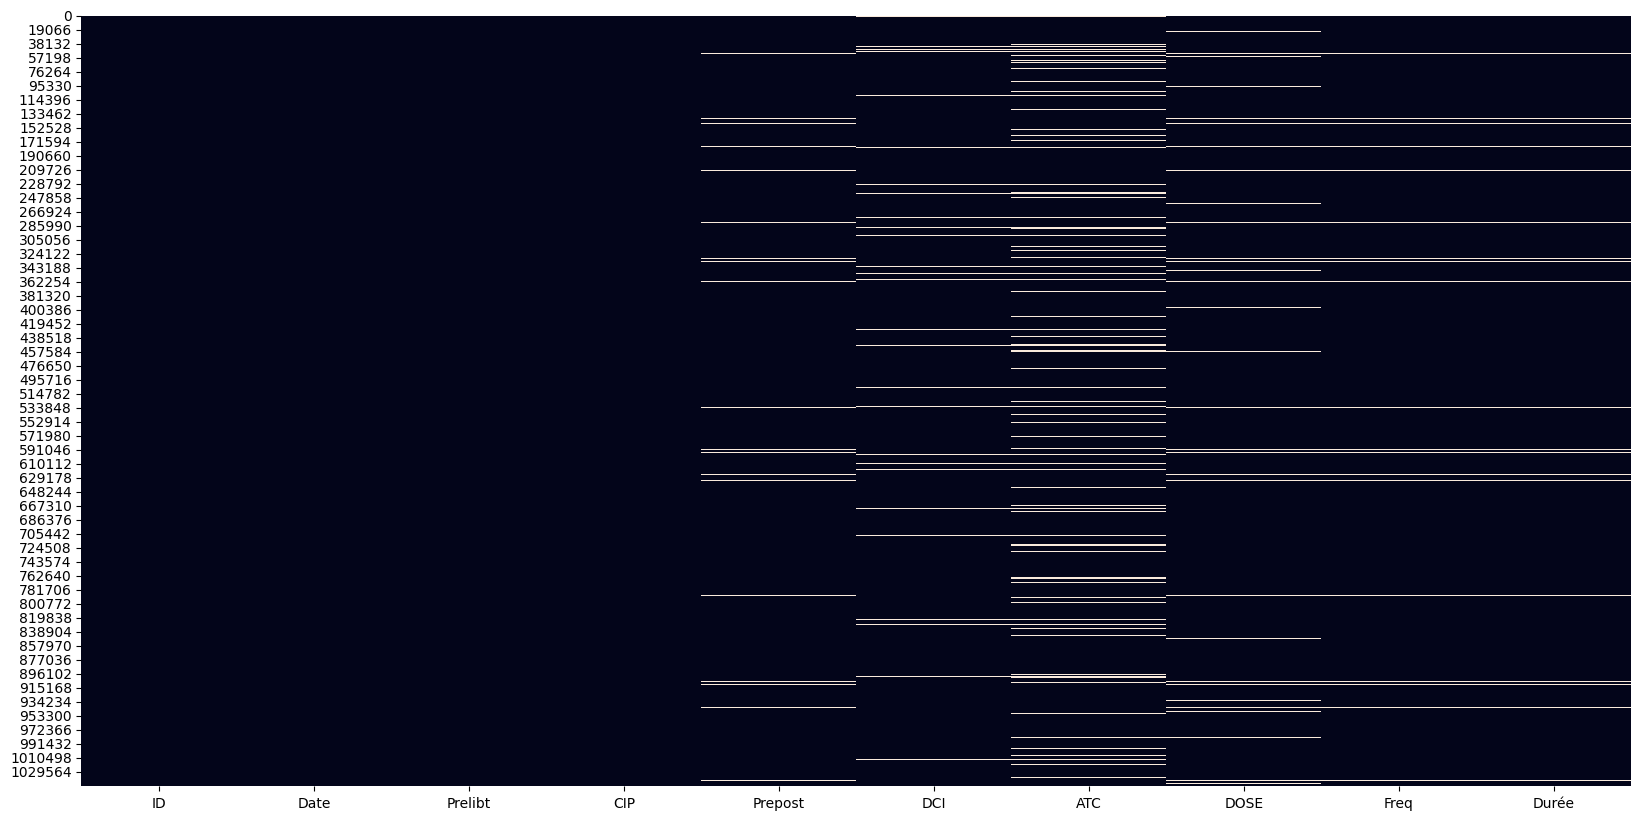

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

In [11]:
df.to_excel("data/out/result.xlsx",index=False)

In [12]:
introuvable = df[df['DCI'].isna()][['Prelibt']]

In [13]:
introuvable["Prelibt"].unique().shape 

(1693,)

In [15]:
introuvable.shape

(37991, 1)

In [16]:
introuvable.value_counts()

Prelibt                           
DEXERYL CR DERM TUB 250G              10417
EMTRICI/TENO 200/245MG BIOG CPR30      1346
DEXERYL CR DERM 250G                    994
GLYCEROL/VASEL/PARA ARW CR TUB250G      990
DEXERYL crème                           836
                                      ...  
NIZORAL cp 200 mg                         1
COUSSIN BURN ROND 42CM AV/HOUSS           1
COTON RECTANGLE NEP 8X10CM 200            1
COSMOPOR E STERIL PANS ADH7,2X5 10        1
COMP 10X2 PHARMAPRIX 10X10CM              1
Name: count, Length: 1693, dtype: int64

In [17]:
introuvable

,Prelibt
32,"BENZATHINE 2,4MUI SDZ PDR+SOL IM 1"
257,DEXERYL CR DERM TUB 250G
258,"SODIUM BICARB 1,4% AGUET 1L 6"
274,DEXERYL CR DERM TUB 250G
275,"SODIUM BICARB 1,4% AGUET 1L 6"
...,...
1048515,DEXERYL CR DERM TUB 250G
1048526,DEXERYL CR DERM TUB 250G
1048538,DEXERYL CR DERM TUB 250G
1048549,DEXERYL CR DERM TUB 250G


In [18]:
introuvable["nom_base"] = introuvable["Prelibt"].str.split().str[0]


In [19]:
introuvable

,Prelibt,nom_base
32,"BENZATHINE 2,4MUI SDZ PDR+SOL IM 1",BENZATHINE
257,DEXERYL CR DERM TUB 250G,DEXERYL
258,"SODIUM BICARB 1,4% AGUET 1L 6",SODIUM
274,DEXERYL CR DERM TUB 250G,DEXERYL
275,"SODIUM BICARB 1,4% AGUET 1L 6",SODIUM
...,...,...
1048515,DEXERYL CR DERM TUB 250G,DEXERYL
1048526,DEXERYL CR DERM TUB 250G,DEXERYL
1048538,DEXERYL CR DERM TUB 250G,DEXERYL
1048549,DEXERYL CR DERM TUB 250G,DEXERYL


In [20]:
introuvable["nom_base"].unique().shape

(636,)

In [21]:
introuvable[["nom_base"]].value_counts()

nom_base           
DEXERYL                14257
EMTRICI/TENO            2442
CLINUTREN               1940
GLYCEROL/VASEL/PARA     1673
MASQUE                  1613
                       ...  
PHOTODERM                  1
DOLGIT                     1
DOCULYSE                   1
PHYTALGIC                  1
MEGAMYLASE                 1
Name: count, Length: 636, dtype: int64

In [22]:
introuvable_11 =introuvable[["nom_base"]].value_counts().reset_index()

In [23]:
introuvable_11.columns = ["nom_base", "count"]

In [24]:
introuvable_11

,nom_base,count
0,DEXERYL,14257
1,EMTRICI/TENO,2442
2,CLINUTREN,1940
3,GLYCEROL/VASEL/PARA,1673
4,MASQUE,1613
...,...,...
631,PHOTODERM,1
632,DOLGIT,1
633,DOCULYSE,1
634,PHYTALGIC,1


In [25]:
introuvable_11.to_excel("INTROUVABLE.xlsx",index=False)

In [62]:
introuvable_11[introuvable_11["count"]>=1000]

,nom_base,count
0,UVEDOSE,63642
1,DOLIPRANE,14370
2,DEXERYL,14257
3,AERIUS,3676
4,IMOVANE,3656
5,KETODERM,3565
6,STILNOX,3222
7,IMODIUM,3156
8,FORTIMEL,2796
9,ATARAX,2576
